# Modelos clásicos para la optimización de carteras de inversión

Este notebook implementa **cuatro enfoques diferentes** para resolver el mismo problema de optimización de portfolios: minimizar el riesgo o maximizar el retorno bajo ciertas restricciones. Los métodos implementados son:

1. **Modelo estándar** - Markowitz clásico
2. **Modelo dual** - maximización de retorno bajo riesgo acotado
3. **Modelo binario aproximado** - selección de activos con variables booleanas, sin pesos continuos
4. **Modelo mixto (binario + pesos)** - combina selección y asignación de pesos.

In [ ]:
!pip install gurobipy cvxpy

Este código prepara los datos para usarlos en los distintos modelos de optimización. A partir del archivo CSV que contiene los precios históricos de acciones de las 505 empresas que forman el S&P 500 a lo largo de 5 años, calcula los retornos diarios por empresa y genera tanto los retornos esperados como la matriz de covarianza entre activos. Esta matriz de covarianza representa cómo varían conjuntamente los retornos de las distintas acciones, es decir, mide la relación entre los movimientos de precio de cada par de activos y es fundamental para cuantificar el riesgo total del portafolio. Luego se seleccionan los activos válidos, se ajusta la matriz para asegurar que sea simétrica y semidefinida positiva (requisito para la optimización convexa), se obtienen los últimos precios disponibles y se definen los parámetros de inversión: presupuesto, retorno mínimo deseado, riesgo máximo aceptado y peso máximo permitido por activo.

In [ ]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("stocks_cleaned.csv")

# Calcular retorno diario por empresa
df['prev_close'] = df.groupby('Name')['close'].shift(1)
df['daily_return'] = (df['close'] - df['prev_close']) / df['prev_close']
df = df.dropna(subset=['daily_return'])

# Retornos esperados y matriz de covarianza
expected_returns = df.groupby('Name')['daily_return'].mean()
pivot_returns = df.pivot(index='date', columns='Name', values='daily_return')
pivot_returns_clean = pivot_returns.replace([np.inf, -np.inf], np.nan).dropna(axis=1, how='any')
cov_matrix_clean = pivot_returns_clean.cov()

# Precios y configuración
tickers = list(pivot_returns_clean.columns)
n = len(tickers)
mu = expected_returns[tickers].values
Sigma = cov_matrix_clean.loc[tickers, tickers].values
Sigma = (Sigma + Sigma.T) / 2
Sigma += 1e-8 * np.eye(n)  # PSD

last_prices = df.sort_values('date').groupby('Name').last()['close'][tickers]
presupuesto = 10_000
min_return = 0.001
max_risk = 0.00006
max_weight = 0.10
min_weight = 0.0051

# Modelo clásico de Markowitz (Minimización del Riesgo)

El modelo de Markowitz, también conocido como Teoría Moderna de Carteras, es una de las metodologías más reconocidas en finanzas cuantitativas para la optimización de carteras. Su objetivo principal es encontrar una asignación de pesos entre distintos activos financieros que **minimice el riesgo total de la cartera**, medido como la varianza de los retornos, manteniendo ciertas restricciones.

En esta implementación, se plantea un problema de optimización convexa donde se minimiza la varianza total de la cartera sujeta a:

- **Restricción de presupuesto**: la suma de los pesos debe ser igual a 1 (es decir, se invierte el 100% del capital disponible).

- **Rentabilidad mínima**: el retorno esperado de la cartera debe ser al menos igual a un umbral deseado (`min_return`).

- **Límite de riesgo máximo**: se impone una cota superior al riesgo total (varianza) permitido (`max_risk`).

- **No apalancamiento**: se prohíbe la inversión corta (los pesos deben ser mayores o iguales que cero).

Este enfoque proporciona una solución eficiente que permite obtener la mejor combinación de activos dados los niveles de retorno y riesgo aceptables para el inversor. El modelo se resuelve utilizando `cvxpy`, una librería de optimización convexa en Python.

Solución óptima encontrada modelo estándar:

Ticker  Acciones   Peso  Retorno esperado (%)  Precio ($)
   ABC      1.19 0.0112                0.0652       94.22
   ALL      0.81 0.0079                0.0659       96.87
  AMZN      0.01 0.0014                0.1508     1416.78
   AWK      6.30 0.0491                0.0600       77.96
   AZO      0.01 0.0011                0.0585      728.33
   BBY      1.22 0.0087                0.1536       71.26
  CBOE      9.96 0.1141                0.1031      114.56
  CHTR      1.02 0.0372                0.1338      363.55
    CI      1.10 0.0216                0.1023      195.44
  CTAS      0.94 0.0148                0.1093      156.60
    DE      1.19 0.0192                0.0526      161.44
    DG      1.71 0.0167                0.0727       97.88
   DPS      3.66 0.0432                0.0826      118.00
    EA      1.13 0.0139                0.1754      123.05
    ED      6.26 0.0471                0.0268       75.26
    EW      0.27 0.0035    

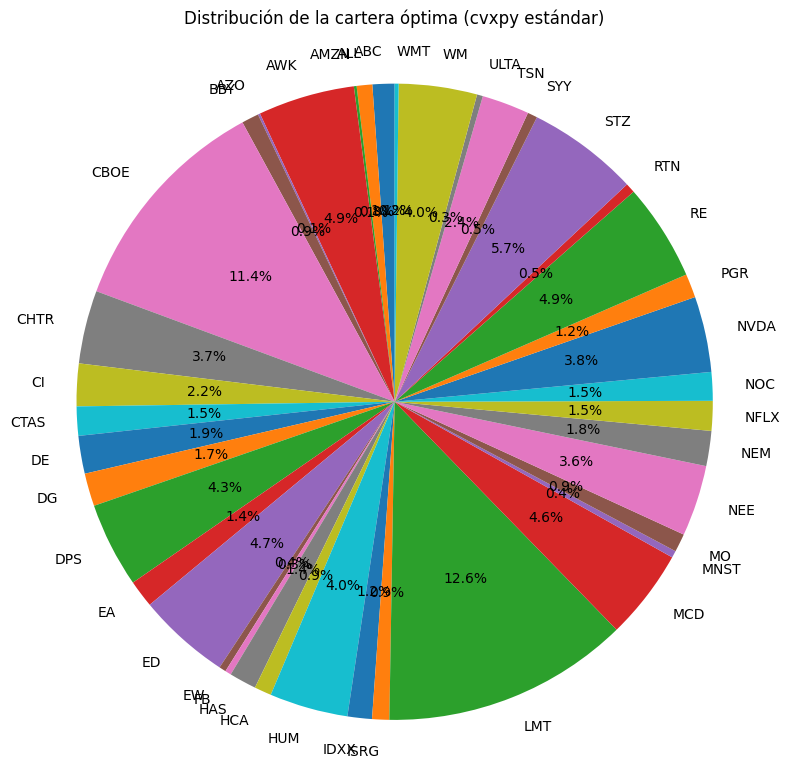

In [ ]:
# Modelo estándar: minimizar la varianza total
w = cp.Variable(n)
objective = cp.Minimize(cp.quad_form(w, Sigma))
constraints = [
    cp.sum(w) == 1,
    mu @ w >= min_return,
    cp.quad_form(w, Sigma) <= max_risk,
    w >= 0,
    #w <= max_weight
]
problem = cp.Problem(objective, constraints)
problem.solve()

weights_std = w.value
ret_std = mu @ weights_std
var_std = weights_std.T @ Sigma @ weights_std

print("Solución óptima encontrada modelo estándar:\n")
data = []
total_invertido = 0

for i in range(n):
    if weights_std[i] > 1e-4:
        ticker = tickers[i]
        peso = weights_std[i]
        retorno = mu[i]
        precio = last_prices[ticker]
        cantidad = (peso * presupuesto) / precio
        total_invertido += cantidad * precio
        data.append({
            "Ticker": ticker,
            "Acciones": round(cantidad, 2),
            "Peso": round(peso, 4),
            "Retorno esperado (%)": round(retorno * 100, 4),
            "Precio ($)": round(precio, 2)
        })

df_std = pd.DataFrame(data)
print(df_std.to_string(index=False))

print(f"\nRetorno diario esperado: {ret_std:.4%}")
print(f"Riesgo (varianza) total: {var_std:.6f}")
print(f"Inversión total: ${total_invertido:.2f}")

# Gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(df_std["Peso"], labels=df_std["Ticker"], autopct='%1.1f%%', startangle=90)
plt.title("Distribución de la cartera óptima (cvxpy estándar)")
plt.axis('equal')
plt.tight_layout()
plt.show()

La solución encontrada por el modelo repersenta una cartera diversificada que cumple con las restricciones impuestas.

**Diversificación**: La cartera resultante asigna peso positivo a casi **40** activos distintos, aunque la mayoría con pesos relativamente bajos (menores al 5%). Esto es característico del modelo de mínima varianza cuando no se impone un límite superior por activo (por ejemplo, un max_weight), lo cual permite asignar pequeñas cantidades a muchos activos para diversificar el riesgo al máximo.

**Activos más relevantes**: Los activos con mayor peso en la cartera son:
- LMT (Lockheed Martin): 12.55%
- CBOE: 11.41%
- STZ (Constellation Brands): 5.65%
- RE, AWK, ED, HUM, WM: entre 3% y 5%

Estos activos destacan por ofrecer una buena relación retorno/volatilidad en el contexto de la matriz de covarianzas utilizada. No son necesariamente los de mayor retorno, sino los que mejor contribuyen a reducir el riesgo total.

**Activos con retorno alto pero bajo peso** : Algunos activos como NVDA, NFLX, FB y EA tienen retornos esperados diarios elevados (superiores al 0.15%), pero reciben un peso pequeño. Esto puede deberse a:
- Alta volatilidad individual
- Alta correlación con otros activos ya seleccionados
- Contribución marginal al riesgo de la cartera

Esto refleja cómo el modelo de Markowitz no se guía únicamente por el retorno esperado, sino por la *eficiencia del activo en reducir la varianza total* dentro del portafolio.

**Retorno y riesgo total**:
- **Retorno esperado diario**: 0.1000% (~25.5% anualizado si asumimos 252 días hábiles)
- **Varianza total**: 0.000041 → **Desviación estándar** ≈ √0.000041 ≈ 0.64% diaria (~10% anualizada)

Esto representa una cartera con un **perfil moderado**: se alcanza el retorno mínimo exigido con un riesgo relativamente bajo, resultado de la diversificación intensiva.

**Capital completamente invertido**: El capital disponible (presupuesto) se ha utilizado casi en su totalidad, con un remanente marginal (inversión total: $9998.95). Esto confirma que el modelo ha sido capaz de cumplir todas las restricciones sin dejar capital sin asignar.

# Modelo dual de Markowitz (Maximización del retorno)

El modelo dual de Markowitz es una reformulación del enfoque clásico de optimización de carteras. Mientras que el modelo estándar (el anterior) busca **minimizar el riesgo** (la varianza del portafolio) dado un retorno mínimo requerido, este modelo invierte el objetivo: busca **maximizar el retorno esperado de la cartera**, sujeto a un nivel de riesgo máximo aceptable.

En este caso, el problema de optimización se plantea de la siguiente manera:
- **Objetivo**: maximizar el retorno esperado total de la cartera.
- **Restricciones**:
     - El **riesgo total** (varianza de la cartera) debe estar por debajo de un umbral definido (max_risk).
     - El **capital total debe estar completamente invertido**, es decir, la suma de los pesos debe ser igual a 1.
     - **No se permite inversión corta o *short-selling***: los pesos deben ser mayores o iguales que cero.

Este enfoque es especialmente útil cuando el inversor está dispuesto a aceptar un nivel de riesgo específico y desea obtener la mayor rentabilidad posible dentro de esos límites. La solución obtenida ofrece una asignación de pesos que aprovecha los activos con mayor retorno ajustado al riesgo, bajo las condiciones establecidas.

Solución óptima encontrada modelo dual:

Ticker  Acciones   Peso  Retorno esperado (%)  Precio ($)
  ALGN      0.78 0.0182                0.1775      234.33
  AMZN      0.07 0.0100                0.1508     1416.78
   AWK      4.63 0.0361                0.0600       77.96
    BA      0.06 0.0020                0.1296      348.12
   BBY      3.46 0.0246                0.1536       71.26
  CBOE      9.86 0.1129                0.1031      114.56
  CHTR      1.53 0.0556                0.1338      363.55
    CI      0.37 0.0073                0.1023      195.44
  CTAS      0.69 0.0108                0.1093      156.60
   DPS      2.52 0.0297                0.0826      118.00
    EA      3.19 0.0392                0.1754      123.05
    FB      0.66 0.0119                0.1660      180.18
   HII      0.47 0.0110                0.1415      234.82
   HUM      1.63 0.0432                0.1074      264.90
  IDXX      1.20 0.0212                0.1181      176.83
   LMT      4.02 0.1389        

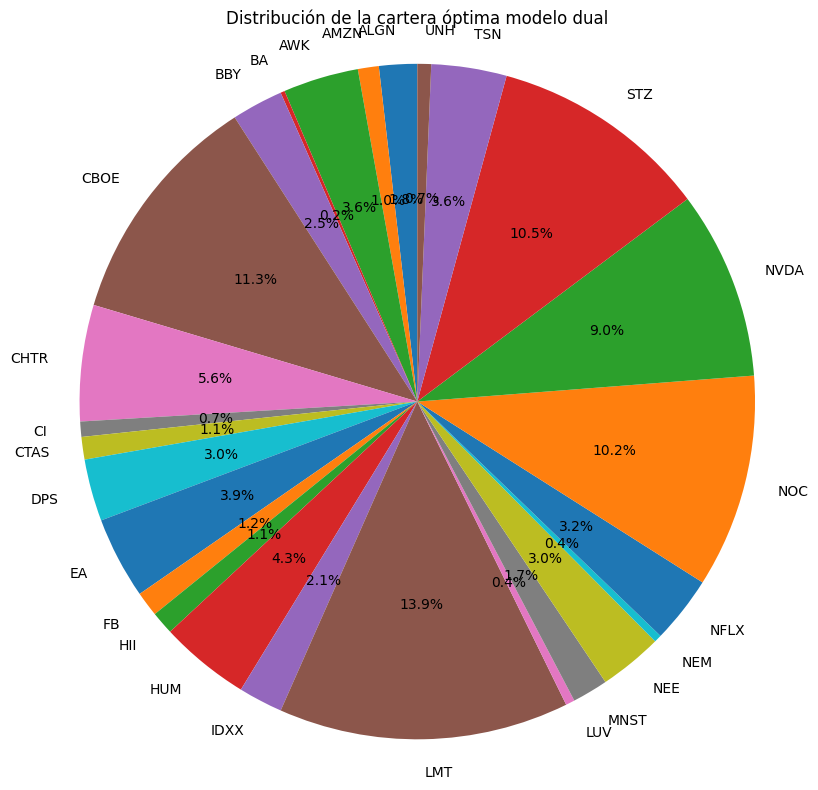

In [ ]:
# Modelo dual: maximizar el retorno esperado
w_dual = cp.Variable(n)
objective_dual = cp.Maximize(mu @ w_dual)
constraints_dual = [
    cp.sum(w_dual) == 1,
    cp.quad_form(w_dual, Sigma) <= max_risk,
    w_dual >= 0,
    #w_dual <= max_weight
]
problem_dual = cp.Problem(objective_dual, constraints_dual)
problem_dual.solve()

weights_dual = w_dual.value
ret_dual = mu @ weights_dual
var_dual = weights_dual.T @ Sigma @ weights_dual

print("Solución óptima encontrada modelo dual:\n")
data = []
total_invertido_dual = 0

for i in range(n):
    if weights_dual[i] > 1e-4:
        ticker = tickers[i]
        peso = weights_dual[i]
        retorno = mu[i]
        precio = last_prices[ticker]
        cantidad = (peso * presupuesto) / precio
        total_invertido_dual += cantidad * precio
        data.append({
            "Ticker": ticker,
            "Acciones": round(cantidad, 2),
            "Peso": round(peso, 4),
            "Retorno esperado (%)": round(retorno * 100, 4),
            "Precio ($)": round(precio, 2)
        })

df_dual = pd.DataFrame(data)
print(df_dual.to_string(index=False))

print(f"\nRetorno total esperado (diario): {ret_dual:.4%}")
print(f"Varianza total: {var_dual:.6f}")
print(f"Inversión total: ${total_invertido_dual:.2f}")

# Gráfico circular
plt.figure(figsize=(8, 8))
plt.pie(df_dual["Peso"], labels=df_dual["Ticker"], autopct='%1.1f%%', startangle=90)
plt.title("Distribución de la cartera óptima modelo dual")
plt.axis('equal')
plt.tight_layout()
plt.show()

La solución resultante refleja un perfil más agresivo que el del modelo clásico (el anterior), priorizando activos de alta rentabilidad dentro de los límites de riesgo establecidos.


**Diversificación**: Aunque el modelo se concentra más que el estándar, sigue incluyendo una selección variada de sectores, lo que sugiere que no hay una dependencia extrema de un solo sector. Esto aporta cierta resiliencia estructural, incluso con un perfil más agresivo.


**Activos más relevantes**: La cartera se centra más en **activos de alto rendimiento**, con mayor concentración de pesos. Destacan:
- LMT (Lockheed Martin): 13.89%
- NOC (Northrop Grumman): 10.22%
- CBOE: 11.29%
- STZ (Constellation Brands): 10.50%
- NVDA (NVIDIA): 9.01%

Estos activos tienen una combinación atractiva de **alto retorno esperado** y **correlación favorable** con el resto de la cartera.


**Retorno y riesgo total**:
- **Retorno esperado diario**: 0.1384% (~37.2% anualizado con 252 días).
- **Varianza total**: 0.000060 → **Desviación estándar/Volatilidad diaria** ≈ 0.77% (~12.2% anualizada).

**Comparación con el modelo estándar**:
- Se **aumenta el retorno** esperado en un 38.4% (de 0.1000% a 0.1384% diario).
- También se **incrementa el riesgo** en un 46% (de 0.000041 a 0.000060 de varianza), aunque sigue dentro del límite permitido.

Esto demuestra que el modelo dual logra una mejora significativa en rentabilidad a costa de asumir más riesgo, pero aún **respetando las restricciones del inversor**.


**Capital completamente invertido**: Toda la inversión disponible se ha aprovechado prácticamente en su totalidad ($9999.63 de $10000), cumpliendo adecuadamente con la restricción de presupuesto.


**Comparación con el modelo estándar**:
- **Mayor concentración**: el modelo dual otorga pesos significativamente más altos a activos seleccionados, reduciendo la diversificación. En la práctica, esto puede conllevar mayor exposición a eventos idiosincráticos.
- **Selección más agresiva**: se observan activos como **NVDA**, **NFLX**, **EA**, **FB** o **ALGN**, que tienen altos retornos esperados pero también alta volatilidad, apenas presentes en el modelo estándar.

# Optimización con Gurobi (Modelo de Markowitz)

Este modelo implementa la optimización de carteras bajo el enfoque clásico de Markowitz utilizando el **solver comercial Gurobi**, uno de los más potentes y eficientes para problemas de programación matemática, especialmente en contextos de gran escala o alta precisión.

A diferencia de los modelos anteriores implementados con `cvxpy`, aquí se utiliza una formulación explícita del problema cuadrático mediante la API de Gurobi en Python:
- **Variables de decisión**: pesos de inversión en cada activo, definidos como variables continuas y no negativas.
- **Objetivo**: minimizar la varianza total de la cartera (medida del riesgo), formulada mediante una expresión cuadrática con la matriz de covarianzas `Σ`.
- **Restricciones**:
     - El **presupuesto total** debe ser invertido: la suma de los pesos es igual a 1.
     - La cartera debe alcanzar un **retorno esperado mínimo** (min_return).
     - No se permite inversión corta (todos los pesos son ≥ 0).

El modelo se resuelve utilizando **Gurobi**, que emplea algoritmos altamente optimizados para resolver problemas de optimización cuadrática convexa (QCP). Al finalizar, se muestra la composición óptima de la cartera, incluyendo los pesos, cantidad de acciones, retorno esperado y la distribución visual en un gráfico circular.

**Gurobi** es un solver de optimización comercial ampliamente utilizado en la industria y la investigación para resolver problemas lineales, cuadráticos, enteros y combinatorios. Ofrece una API en múltiples lenguajes, entre ellos Python, y destaca por su rapidez, escalabilidad y calidad de soluciones. Requiere licencia (gratuita para uso académico).

Set parameter Username
Set parameter LicenseID to value 2660136
Academic license - for non-commercial use only - expires 2026-05-02
Solución óptima encontrada (Gurobi):

Ticker  Acciones   Peso  Retorno esperado (%)  Precio ($)
  AAPL      0.02 0.0003                0.0786      159.54
   ABC      1.19 0.0112                0.0652       94.22
   ALL      0.81 0.0078                0.0659       96.87
  AMZN      0.01 0.0014                0.1508     1416.78
   AWK      6.30 0.0491                0.0600       77.96
   AZO      0.02 0.0011                0.0585      728.33
   BBY      1.22 0.0087                0.1536       71.26
  CBOE      9.96 0.1141                0.1031      114.56
  CHTR      1.02 0.0372                0.1338      363.55
    CI      1.10 0.0216                0.1023      195.44
  CTAS      0.94 0.0147                0.1093      156.60
    DE      1.19 0.0191                0.0526      161.44
    DG      1.71 0.0167                0.0727       97.88
   DPS      3.66 0

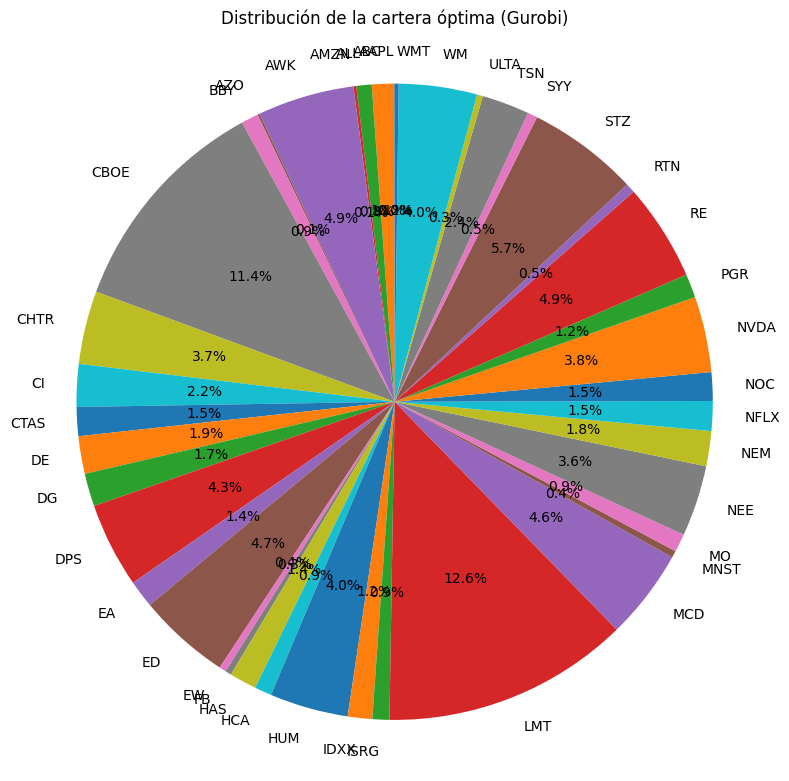

In [ ]:
from gurobipy import Model, GRB, QuadExpr

# Crear modelo con Gurobi
model = Model("Markowitz-Gurobi")
model.setParam("OutputFlag", 0)  # Silenciar salida

# Variables de decisión: pesos [0, max_weight]
#w = {i: model.addVar(lb=0.0, ub=max_weight, name=f"w_{i}") for i in range(n)}
w = {i: model.addVar(lb=0.0, name=f"w_{i}") for i in range(n)}


# Restricción: suma de pesos = 1
model.addConstr(sum(w[i] for i in range(n)) == 1, "presupuesto")

# Restricción: retorno mínimo
model.addConstr(sum(mu[i] * w[i] for i in range(n)) >= min_return, "retorno_min")

# Objetivo: minimizar varianza (riesgo)
risk = QuadExpr()
for i in range(n):
    for j in range(n):
        risk.add(w[i] * w[j] * Sigma[i][j])
model.setObjective(risk, GRB.MINIMIZE)

# Resolver
model.optimize()

# Mostrar resultados
if model.status == GRB.OPTIMAL:
    print("Solución óptima encontrada (Gurobi):\n")
    total_return = sum(mu[i] * w[i].X for i in range(n))
    total_risk = sum(w[i].X * w[j].X * Sigma[i][j] for i in range(n) for j in range(n))
    total_invertido = 0

    data = []
    for i in range(n):
        if w[i].X > 1e-4:
            ticker = tickers[i]
            peso = w[i].X
            precio = last_prices[ticker]
            retorno = mu[i]
            cantidad = (peso * presupuesto) / precio
            total_invertido += cantidad * precio
            data.append({
                "Ticker": ticker,
                "Acciones": round(cantidad, 2),
                "Peso": round(peso, 4),
                "Retorno esperado (%)": round(retorno * 100, 4),
                "Precio ($)": round(precio, 2)
            })

    df_gurobi = pd.DataFrame(data)
    print(df_gurobi.to_string(index=False))

    print(f"\nRetorno total esperado (diario): {total_return:.4%}")
    print(f"Varianza total: {total_risk:.6f}")
    print(f"Inversión total: ${total_invertido:.2f}")

    # Gráfico circular
    plt.figure(figsize=(8, 8))
    plt.pie(df_gurobi["Peso"], labels=df_gurobi["Ticker"], autopct='%1.1f%%', startangle=90)
    plt.title("Distribución de la cartera óptima (Gurobi)")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

else:
    print("No se encontró una solución óptima.")

La solución obtenida con Gurobi reproduce el comportamiento del **modelo estándar de Markowitz**, ya que el objetivo es **minimizar la varianza** (riesgo) con una restricción sobre el **retorno mínimo**. Dado que se modeló el mismo problema que en cvxpy, los resultados sirven también como **validación cruzada entre solvers**.


**Diversificación**: La cartera incluye más de 40 activos con pesos pequeños, igual que en el modelo clásico. Esto se debe a que **minimizar la varianza en presencia de restricciones de no-negatividad y retorno mínimo** incentiva la diversificación extensa para distribuir el riesgo.


**Activos más relevantes**: Entre los activos con mayor peso encontramos:
- LMT (Lockheed Martin): 12.55%
- CBOE: 11.41%
- STZ, AWK, RE, ED, WM: entre 4% y 5%

Esto coincide estrechamente con los activos dominantes en el modelo clásico de `cvxpy`.


**Retorno y riesgo total**:
- **Retorno esperado diario**:  0.1000% (≈ 25.5% anualizado)
- **Varianza total**: 0.000041 → **Desviación estándar/Volatilidad diaria** ≈  0.64%.
- **Inversión total**: $9998.39

Estos valores son prácticamente idénticos a los obtenidos con cvxpy, lo que demuestra que **Gurobi encuentra la misma solución óptima** (o numéricamente equivalente) bajo las mismas restricciones.

-> **Validación importante**: Gurobi y cvxpy resuelven el mismo problema con resultados coincidentes, lo cual confirma que el modelo ha sido correctamente formulado y resuelto en ambos entornos.


**Estrategia del modelo**: La distribución refleja una estrategia conservadora que intenta minimizar el riesgo manteniendo un retorno aceptable. No hay grandes apuestas individuales, sino un equilibrio de activos con riesgo y retorno moderado.

También aparecen algunos activos con retornos elevados como:
- NVDA (25.63%)
- NFLX (22.17%)
- EA (17.54%)
...pero con pesos bajos, debido a su elevada volatilidad individual.


**Conclusión**: Este modelo con Gurobi **replica fielmente** la lógica del modelo estándar implementado en cvxpy. Demuestra la **consistencia entre solvers**, algo clave en entornos de producción o auditoría. Gurobi, al ser un solver más avanzado, ofrece ventajas si se amplía el modelo a casos más complejos (restricciones enteras, variables binarias, cardinalidad, etc.).



# Optimización cuadrática con variables booleanas (cvxpy)

Este modelo extiende la formulación clásica de Markowitz incorporando una capa adicional de **selección discreta de activos**. Se trata de un caso de **optimización cuadrática entera mixta (MIQP)**, en el que se optimizan tanto los **pesos continuos de inversión** como la **selección binaria** de qué activos incluir en la cartera. La formulación del modelo es la siguiente:

- **Variables de decisión**:
     - w: pesos continuos de inversión por activo (entre 0 y 1).
     - x: variables booleanas que indican si un activo está incluido (x_i = 1) o no (x_i = 0) en la cartera.

- **Objetivo**: maximizar el **retorno esperado total** de la cartera.
- **Restricciones**:
     - La suma total de los pesos debe ser igual a 1 (todo el presupuesto debe invertirse).
     - No se permiten posiciones cortas (w_i ≥ 0).
     - Solo se puede asignar peso a un activo si está seleccionado (w_i ≤ x_i).
     - El retorno esperado total debe ser al menos igual a un umbral (min_return).
     - El riesgo total (varianza) debe estar por debajo de un máximo permitido (max_risk).
     - El valor monetario total invertido debe respetar el presupuesto disponible.
     - Se impone un límite máximo al número de activos seleccionados (∑x_i ≤ 20), lo que introduce un componente de *cardinalidad*.

El problema se resuelve mediante el solver **ECOS_BB**, una herramienta de **cvxpy** que permite manejar problemas con variables binarias de forma eficiente. Este tipo de optimización es especialmente útil en escenarios reales donde se desea controlar el número de activos en cartera (por simplicidad operativa, costes de gestión, etc.).

**Ventajas de este enfoque**:
- Refleja restricciones prácticas más realistas.
- Controla el número de activos, evitando carteras excesivamente diversificadas con muchos activos de bajo impacto.
- Permite combinar la potencia de la teoría de Markowitz con reglas de negocio del mundo real.

In [ ]:
pip install ecos


Note: you may need to restart the kernel to use updated packages.


Solución óptima encontrada (cvxpy mixto):

Ticker  Acciones   Peso  Retorno esperado (%)  Precio ($)
  ALGN      0.86 0.0200                0.1775      234.33
   AWK      5.15 0.0402                0.0600       77.96
   BBY      3.57 0.0254                0.1536       71.26
  CBOE     10.01 0.1146                0.1031      114.56
  CHTR      1.58 0.0574                0.1338      363.55
  CTAS      1.06 0.0165                0.1093      156.60
   DPS      2.60 0.0307                0.0826      118.00
    EA      3.30 0.0407                0.1754      123.05
    FB      0.80 0.0145                0.1660      180.18
   HUM      1.86 0.0493                0.1074      264.90
  IDXX      1.33 0.0234                0.1181      176.83
   LMT      4.25 0.1469                0.1138      345.43
  MNST      2.78 0.0180                0.1312       64.55
   NEE      2.10 0.0312                0.0626      148.09
  NFLX      1.29 0.0340                0.2217      264.56
   NOC      3.12 0.1055      

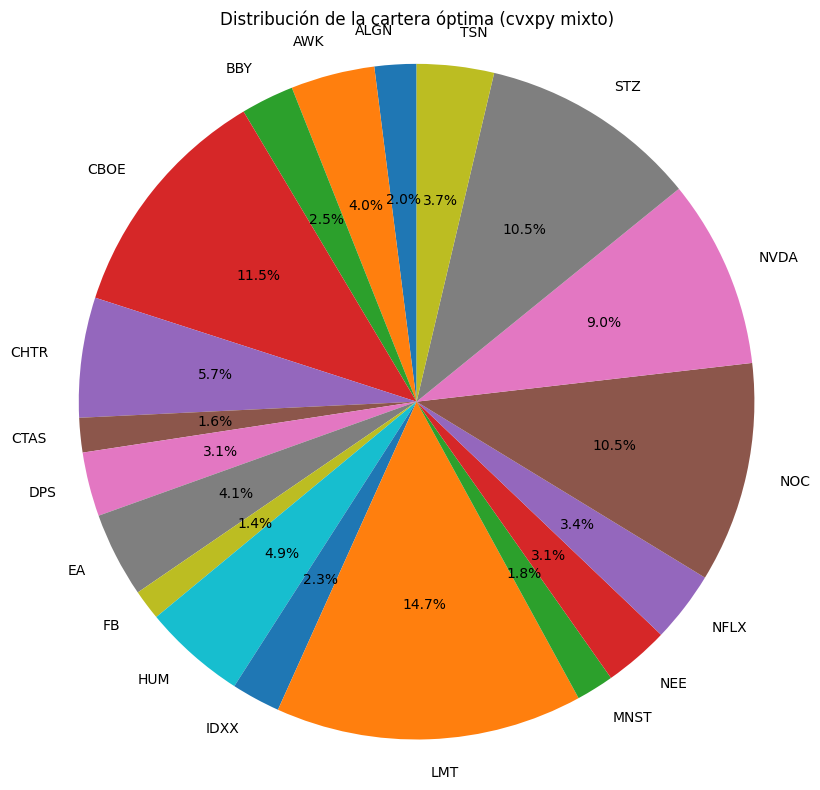

In [ ]:
# Optimización Mixta => pesos + selección binaria

# Variables de decisión
w = cp.Variable(n)                  # pesos continuos
x = cp.Variable(n, boolean=True)   # selección binaria

# Restricciones
constraints = [
    cp.sum(w) == 1,
    w >= 0,
    w <= x,
    mu @ w >= min_return,
    cp.quad_form(w, Sigma) <= max_risk,
    last_prices.values @ w <= presupuesto,
    cp.sum(x) <= 20
]

# Objetivo
objective = cp.Maximize(mu @ w)

# Resolver
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.ECOS_BB)

# Mostrar resultados en tabla
if w.value is not None and x.value is not None:
    print("Solución óptima encontrada (cvxpy mixto):\n")
    data = []

    total_return = float(mu @ w.value)
    total_risk = float(w.value.T @ Sigma @ w.value)
    total_invertido = 0

    for i in range(n):
        if w.value[i] > 1e-4:
            ticker = tickers[i]
            peso = w.value[i]
            precio = last_prices[ticker]
            retorno = mu[i]
            cantidad = (peso * presupuesto) / precio
            total_invertido += cantidad * precio
            data.append({
                "Ticker": ticker,
                "Acciones": round(cantidad, 2),
                "Peso": round(peso, 4),
                "Retorno esperado (%)": round(retorno * 100, 4),
                "Precio ($)": round(precio, 2)
            })

    df_resultado = pd.DataFrame(data)
    print(df_resultado.to_string(index=False))

    print(f"\nRetorno total esperado (diario): {total_return:.4%}")
    print(f"Varianza total: {total_risk:.6f}")
    print(f"Inversión total: ${total_invertido:.2f}")

    # Gráfico circular
    plt.figure(figsize=(8, 8))
    plt.pie(df_resultado["Peso"], labels=df_resultado["Ticker"], autopct='%1.1f%%', startangle=90)
    plt.title("Distribución de la cartera óptima (cvxpy mixto)")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontró solución óptima.")


Este modelo permite no solo decidir **cuánto invertir** en cada activo, sino también **en qué activos invertir**, mediante la inclusión de variables booleanas de selección (`x`). Se impuso una restricción de cardinalidad de **máximo 20 activos**, lo que limita deliberadamente la diversificación y simula una estrategia realista de inversión.


**Activos más relevantes**: Entre los activos con mayor peso encontramos:
- LMT (Lockheed Martin): 14.69%
- CBOE: 11.46%
- NOC: 10.55%
- STZ: 10.46%
- NVDA: 9.02%

Estos activos también aparecen con alta ponderación en el modelo dual, lo cual indica consistencia en la identificación de activos eficientes en términos de retorno-riesgo.


**Retorno y riesgo total**:
- **Retorno esperado diario**: 0.1383% (≈ 37.2% anualizado).
- **Varianza total**: 0.000060 → **Desviación estándar/Volatilidad diaria** ≈  0.77%.
- **Inversión total**: $10,000.00 exactos.

Este rendimiento y riesgo **coinciden prácticamente con el modelo dual**, lo cual es destacable porque el modelo dual no impone restricciones de cardinalidad. El hecho de que se haya alcanzado el mismo retorno y riesgo con **solo 19 activos** sugiere que el modelo mixto fue capaz de encontrar una cartera altamente eficiente dentro de los límites impuestos.


**Estrategia del modelo**: A diferencia de los modelos clásicos que dispersan capital en muchos activos con pesos pequeños, este modelo:
- **Reduce significativamente la diversificación**.
- **Focaliza la inversión en activos de alta calidad estadística**, bajo las restricciones del presupuesto y del riesgo.
- **Reproduce el retorno del modelo dual**, pero de forma más pragmática.
Este tipo de solución es particularmente útil cuando el número de activos debe ser reducido por razones de gestión, regulación o costes operativos.


**Conclusión**: Este modelo con Gurobi **replica fielmente** la lógica del modelo estándar implementado en cvxpy. Demuestra la **consistencia entre solvers**, algo clave en entornos de producción o auditoría. Gurobi, al ser un solver más avanzado, ofrece ventajas si se amplía el modelo a casos más complejos (restricciones enteras, variables binarias, cardinalidad, etc.).

# Conclusión general

Los modelos dual y mixto ofrecen el mayor retorno diario, pero con mayor riesgo.

El modelo mixto binario logra una cartera casi idéntica al dual pero con menos activos, lo cual es ideal en entornos donde la simplicidad y la operatividad son importantes.

Gurobi y cvxpy dan resultados equivalentes en el modelo clásico, lo que valida la formulación y abre la puerta a usar Gurobi en problemas más complejos o con restricciones adicionales (como integrales o cardinalidad exacta).

Si se busca robustez y diversificación, el modelo clásico es más conservador. Si se desea agresividad o eficiencia operativa, el modelo mixto binario es la mejor opción.

In [ ]:
import pandas as pd

# Crear la tabla como DataFrame
data = {
    "Modelo": [
        "Markowitz clásico (cvxpy)",
        "Markowitz dual (cvxpy)",
        "Markowitz clásico (Gurobi)",
        "Opt. mixta binaria (cvxpy)"
    ],
    "Activos": ["~40", "~25", "~40", "19"],
    "Retorno diario (%)": [0.1000, 0.1384, 0.1000, 0.1383],
    "Varianza total": [0.000041, 0.000060, 0.000041, 0.000060],
    "Volatilidad diaria (%)": [0.6403, 0.7746, 0.6403, 0.7746],
    "Inversión total": ["$9998.95", "$9999.63", "$9998.39", "$10000.00"]
}

df = pd.DataFrame(data)

# Mostrar la tabla
df


,Modelo,Activos,Retorno diario (%),Varianza total,Volatilidad diaria (%),Inversión total
0,Markowitz clásico (cvxpy),~40,0.1000,0.000041,0.6403,$9998.95
1,Markowitz dual (cvxpy),~25,0.1384,0.000060,0.7746,$9999.63
2,Markowitz clásico (Gurobi),~40,0.1000,0.000041,0.6403,$9998.39
3,Opt. mixta binaria (cvxpy),19,0.1383,0.000060,0.7746,$10000.00


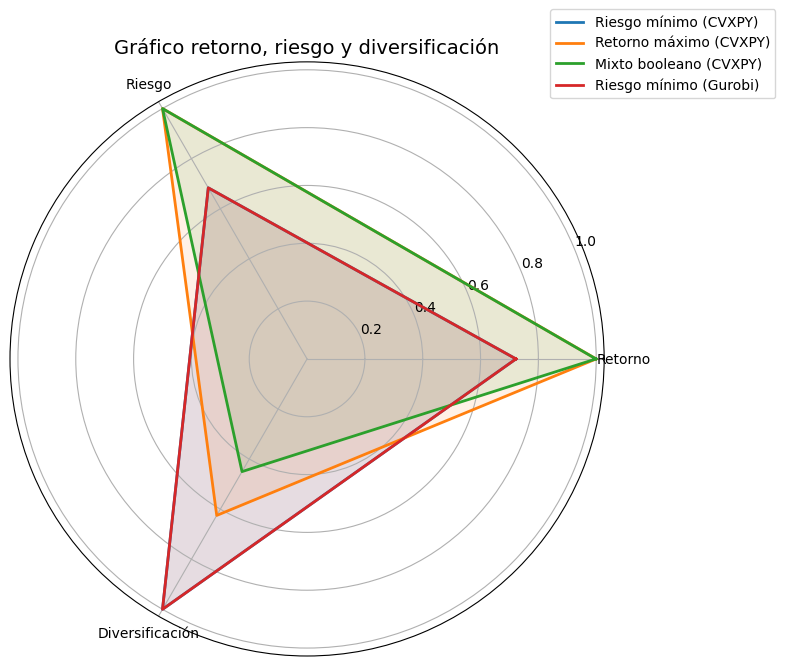

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from math import pi

# Datos de los modelos
modelos = [
    {
        "Modelo": "Riesgo mínimo (CVXPY)",
        "Retorno esperado (%)": 0.1000,
        "Varianza total": 0.000041,
        "Activos seleccionados": 40,
        "Inversión total ($)": 9998.95
    },
    {
        "Modelo": "Retorno máximo (CVXPY)",
        "Retorno esperado (%)": 0.1384,
        "Varianza total": 0.000060,
        "Activos seleccionados": 25,
        "Inversión total ($)": 9999.63
    },
    {
        "Modelo": "Mixto booleano (CVXPY)",
        "Retorno esperado (%)": 0.1383,
        "Varianza total": 0.000060,
        "Activos seleccionados": 18,
        "Inversión total ($)": 10000.00
    },
    {
        "Modelo": "Riesgo mínimo (Gurobi)",
        "Retorno esperado (%)": 0.1000,
        "Varianza total": 0.000041,
        "Activos seleccionados": 40,
        "Inversión total ($)": 9998.39
    }
]

df_modelos = pd.DataFrame(modelos)

# Normalizamos los valores para graficar
radar_df = df_modelos.copy()
radar_df["Retorno"] = radar_df["Retorno esperado (%)"] / radar_df["Retorno esperado (%)"].max()
radar_df["Riesgo"] = radar_df["Varianza total"] / radar_df["Varianza total"].max()
radar_df["Diversificación"] = radar_df["Activos seleccionados"] / radar_df["Activos seleccionados"].max()

radar_data = radar_df[["Modelo", "Retorno", "Riesgo", "Diversificación"]].set_index("Modelo")

# Configuración del radar
categories = radar_data.columns
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Crear gráfico radar
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

for idx, row in radar_data.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, label=idx)
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_title("Gráfico retorno, riesgo y diversificación", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()
